# LOTR Network Notebook

This is a notebook to create a network relationship graph between characters in the Lord of the Rings books. It relies upon the scraped list of characters taken from <a href="https://www.scarymommy.com/lord-of-the-rings-names">here</a>. If there's a better list, then we should substitute that for the current list we're using. This code is inspired by <a href="https://github.com/thu-vu92/the_witcher_network">this repo</a> which used the Witcher book series to develop a relationship network graph.

## Import Libraries 

Import the required libraries and load the English language model from the spacy library

In [132]:
import os
import json
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import community.community_louvain as community_louvain

NER = spacy.load("en_core_web_sm")

## Load the Books into the Environment

We'll now load the '.txt' files of the three books into our python environment. Then we'll check that they've been loaded correctly and look over the model analysis.

In [89]:
all_books = [b for b in os.scandir('Books') if '.txt' in b.name]

all_books

[<DirEntry '01 - The Fellowship Of The Ring.txt'>,
 <DirEntry '02 - The Two Towers.txt'>,
 <DirEntry '03 - The Return Of The King.txt'>]

In [7]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [66]:
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

## Load Character Names

Next we'll load the '.json' list of character names into our environment. I have tried to edit these as much as possible, although this may need some tweaking going forward. 

We would also ideally have a 'book' category so we would be able to filter by book. However, I haven't been able to find a source for this we could use. 

Another issue is the presence of non-ASCII characters amongst the strings. Ideally they would be recorded in the list exactly how they are in the text files, so we may have to find character names and re-input them identically to how they are recorded in the book.



In [68]:
characters = json.loads(open('LOTR_characters.json', encoding="utf-8").read())
characters

['Aldor',
 'Anborn',
 'Angelica',
 'Angbor',
 'Aragorn',
 'Arwen',
 'Bilbo',
 'Frodo',
 'Balin',
 'Beechbone',
 'Bregalad',
 'Boromir',
 'Bruno',
 'Merry',
 'Mrs. Bracegirdle',
 'Melilot',
 'Carl Cotton',
 'Celeborn',
 'Cirdan',
 'Rosie',
 'Déagol',
 'Denethor',
 'Elendil',
 'Elrond',
 'Éomer',
 'Éomund',
 'Éothain',
 'Éowyn',
 'Faramir',
 'Fastred',
 'Finglas',
 'Filibert Bolger',
 'Fladrif',
 'Fredegar Bolger',
 'Galadriel',
 'Sam',
 'Gandalf',
 'Gimli',
 'Gleowine',
 'Gollum',
 'Grima',
 'Hamfast',
 'Isildur',
 'Khamûl',
 'Legolas',
 'Nazgul',
 'Farmer Maggot',
 'Saruman',
 'Shelob',
 'Pippin',
 'Treebeard',
 'Old Noakes',
 'Mrs. Proudfoot',
 'Odo Proudfoot',
 'Otho Sackville-Baggins',
 'Lobelia Sackville-Baggins',
 'Ted Sandyman',
 'Diamond Took',
 'Bard the Bowman',
 'Barliman Butterbur',
 'Arwen',
 'Figwit',
 'Forlong',
 'Elrond',
 'Erestor',
 'Nestadion',
 'Silinde',
 'Celeborn',
 'Galadriel',
 'Haldir',
 'Nilfaleth',
 'Rúmil',
 'Damrod',
 'Denethor',
 'Eldarion',
 'Elendil',
 '

## Sentence Entity Data Frame

The next thing we'll need to do is begin to develop our entity-by-sentence data frame. This will serve as the beginnings of our network data. <b>This will take some time to run</b>.

In [69]:
sent_entity_df = []

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [70]:
sent_entity_df.head(50)

,sentence,entities
0,"( , THE, TWO, TOWERS, \n\n ...","[TWO, SECOND, Rings, Chapter 1]"
1,"(Every, now, and, again, he, bent, to, the, gr...",[]
2,"(Hobbits, go, light, ,, and, their, footprints...",[]
3,"(\n , ', I, read, the, signs, aright, ,, '...",[]
4,"(', Frodo, ran, to, the, hill, -, top, .)",[]
5,"(I, wonder, what, he, saw, there, ?)",[]
6,"(But, he, returned, by, the, same, way, ,, and...",[]
7,"(He, desired, to, go, to, the, high, seat, him...",[]
8,"(Suddenly, he, leaped, forward, ,, and, ran, t...",[]
9,"(Then, sitting, in, the, high, seat, he, looke...",[]


## Converting to a Character to Character Data Frame

With this, we can then filter out the non-character entities using the json character list that we loaded earlier. We'll define a function for this purpose and then filter the resultant data frame to produce a character-to-character relationship data frame.

In [71]:
def filter_entity(ent_list, characters):
    return [ent for ent in ent_list 
            if ent in list(characters)]

In [119]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters))

sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
16,"(\n , ', The, horn, of, Boromir, !, ')",[Boromir],[Boromir]
22,"(Where, is, Sam, ?, ', \n , As, he, ran, t...",[Sam],[Sam]
27,"(\n , A, mile, ,, maybe, ,, from, Parth, G...","[Parth Galen, Boromir]",[Boromir]
32,"(Boromir, opened, his, eyes, and, strove, to, ...",[Boromir],[Boromir]
43,"(\n , ', Farewell, ,, Aragorn, !)",[Aragorn],[Aragorn]
45,"(I, have, failed, ., ', \n , ', No, !, ', ...",[Aragorn],[Aragorn]
49,"(Minas, Tirith, shall, not, fall, !, ', \n ...","[Minas Tirith, Boromir]",[Boromir]
52,"(said, Aragorn, .)",[Aragorn],[Aragorn]
53,"(\n , But, Boromir, did, not, speak, again...",[Boromir],[Boromir]
54,"(\n , ', Alas, !, ', said, Aragorn, ., ')",[Aragorn],[Aragorn]


In [120]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [121]:
relationship_df = pd.DataFrame(relationships)

In [122]:
relationship_df.head(10)

,source,target
0,Sam,Boromir
1,Aragorn,Boromir
2,Aragorn,Boromir
3,Boromir,Aragorn
4,Boromir,Aragorn
5,Aragorn,Boromir
6,Boromir,Aragorn
7,Aragorn,Boromir
8,Boromir,Aragorn
9,Aragorn,Boromir


In [123]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

relationship_df.head(10)

,source,target,value
0,Sam,Boromir,13
1,Aragorn,Boromir,48
2,Boromir,Aragorn,41
3,Aragorn,Denethor,14
4,Denethor,Gandalf,2
5,Gandalf,Boromir,16
6,Boromir,Legolas,18
7,Legolas,Gimli,186
8,Gimli,Legolas,207
9,Legolas,Aragorn,143


## Create Graph and Community Visualisation

With this data, we can now undertake our graph analysis and build some graph visualisations.

In [124]:
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

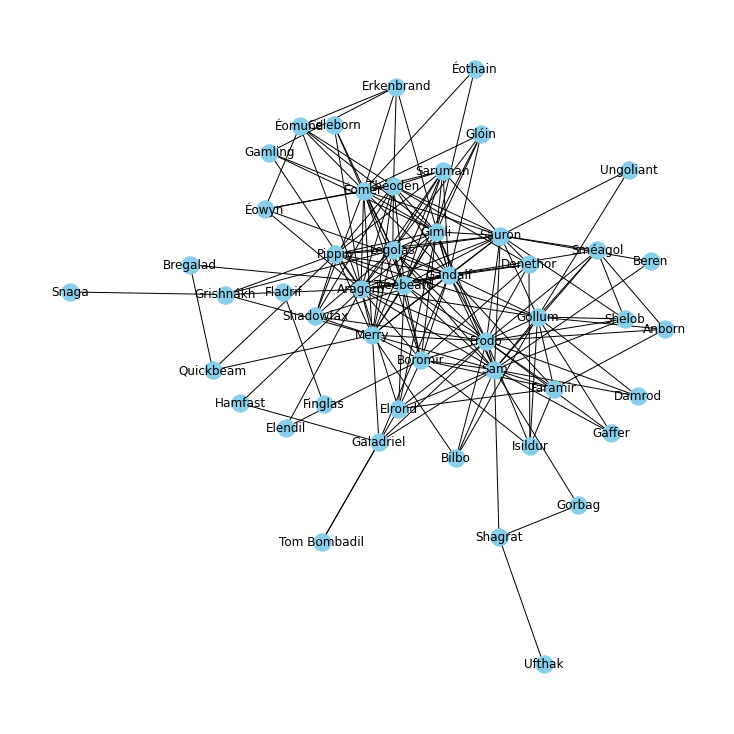

In [125]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [1]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("lotr.html")

NameError: name 'Network' is not defined

In [131]:
communities = community_louvain.best_partition(G)
communities

{'Sam': 0,
 'Boromir': 0,
 'Aragorn': 2,
 'Denethor': 0,
 'Gandalf': 2,
 'Legolas': 2,
 'Gimli': 2,
 'Frodo': 0,
 'Sauron': 0,
 'Saruman': 2,
 'Pippin': 2,
 'Éomund': 2,
 'Éomer': 2,
 'Éothain': 2,
 'Théoden': 2,
 'Celeborn': 2,
 'Elrond': 0,
 'Merry': 2,
 'Grishnákh': 2,
 'Snaga': 2,
 'Shadowfax': 2,
 'Gollum': 0,
 'Bilbo': 0,
 'Treebeard': 2,
 'Tom Bombadil': 3,
 'Galadriel': 3,
 'Fladrif': 4,
 'Finglas': 4,
 'Bregalad': 2,
 'Quickbeam': 2,
 'Glóin': 2,
 'Elendil': 0,
 'Éowyn': 2,
 'Erkenbrand': 2,
 'Gamling': 2,
 'Sméagol': 0,
 'Gaffer': 0,
 'Isildur': 0,
 'Hamfast': 3,
 'Faramir': 0,
 'Damrod': 0,
 'Anborn': 0,
 'Shelob': 0,
 'Beren': 0,
 'Ungoliant': 0,
 'Shagrat': 1,
 'Gorbag': 1,
 'Ufthak': 1}

In [134]:
nx.set_node_attributes(G, communities, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("lotr_communities.html")